<a href="https://colab.research.google.com/github/hazieon/Exoplanet-Detection/blob/dev/Kepler_Exoplanet(Project_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#connecting to google drive to bring in the datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [53]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display
import numpy as np

In [54]:
#file_path='/content/drive/MyDrive/KeplerExoplanet/K2_Planets_and_candidates_NASA.csv'

#file_path='/content/drive/MyDrive/KeplerExoplanet/kepler_dataset.csv'
# df=pd.read_csv('/content/drive/MyDrive/KeplerExoplanet/kepler_dataset.csv')
#df=pd.read_csv('/content/drive/MyDrive/KeplerExoplanet/K2_Planets_and_candidates_NASA.csv')
#df=pd.read_csv('/content/drive/MyDrive/KeplerExoplanet/K2_Planets_and_candidates_NASA.csv')
# df=pd.read_csv('/content/drive/MyDrive/KeplerExoplanet/TESS_data.csv')

#wecan directly use column names with header=0
#7803 data points 39 feature columns
#print few rows of starting default 5

# Kepler data stared at one field of space for four years,
# Looking deeper at the K2 data can provide a new angle of analysing exoplanet features

df = pd.read_csv(
    '/content/drive/MyDrive/KeplerExoplanet/k2_exoplanets_SUBSAMPLED_NASA_DATA.csv',
    comment='#'
)

# PREPROCESSING DATA -
# Strip column names of leading/trailing spaces
df.columns = df.columns.str.strip()

# List of numeric columns to convert
numeric_cols = ['pl_rade', 'pl_eqt', 'pl_orbper', 'pl_insol', 'st_teff', 'st_rad']

# Convert each column to float data type
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df=df.loc[:3800]

# Take a look at the data -
print(df.head(5))

# Dataset overview
print("Rows:", df.shape[0])
print("Columns:", df.shape[1])
print("Total NaNs:", df.isna().sum().sum())
print("Total valid values:", df.size - df.isna().sum().sum())

# Define key columns to check for NaNs
key_columns = ['sy_pnum', 'sy_dist', 'pl_name', 'disposition']  # adjust as needed

# Drop columns with >50% NaN in the key columns
cols_to_drop = [col for col in df.columns if df[col].isna().mean() > 0.5 ]
df = df.drop(columns=cols_to_drop)

# Drop rows where any key column has >50% NaN
rows_to_drop = df[df[key_columns].isna().mean(axis=1) > 0.5].index
df = df.drop(index=rows_to_drop)

# Quick sanity check
print(f"Rows remaining: {df.shape[0]}")
print(f"Columns remaining: {df.shape[1]}")
print(f"Total NaNs: {df.isna().sum().sum()}")



             pl_name        hostname  default_flag disposition  \
0        BD+20 594 b       BD+20 594             0   CONFIRMED   
1        BD+20 594 b       BD+20 594             0   CONFIRMED   
2        BD+20 594 b       BD+20 594             1   CONFIRMED   
3  EPIC 201111557.01  EPIC 201111557             1   CANDIDATE   
4  EPIC 201111557.01  EPIC 201111557             0   CANDIDATE   

             disp_refname  sy_snum  sy_pnum discoverymethod  disc_year  \
0    Espinoza et al. 2016      1.0      1.0         Transit     2016.0   
1    Espinoza et al. 2016      1.0      1.0         Transit     2016.0   
2    Espinoza et al. 2016      1.0      1.0         Transit     2016.0   
3  Livingston et al. 2018      1.0      0.0         Transit     2018.0   
4  Livingston et al. 2018      1.0      0.0         Transit     2018.0   

  disc_facility  ... sy_vmagerr2  sy_kmag sy_kmagerr1  sy_kmagerr2  \
0            K2  ...      -0.012    9.368       0.018       -0.018   
1            K2  .

In [70]:
# PREPROCESSING DATA

# Label the binary target: 1 = CONFIRMED, 0 = non-planets and candidates
# We took a more conservative approach and excluded candidates from the exoplanet category
df['ConfirmedExoplanet'] = df['disposition'].apply(lambda x: 1 if x == 'CONFIRMED' else 0)

# Separate confirmed and non-confirmed planets
confirmed = df[df['ConfirmedExoplanet'] == 1]
non_planet = df[df['ConfirmedExoplanet'] == 0]


# Columns to drop (non-numeric)
non_numeric_columns = [
    'pl_name', 'hostname', 'disposition', 'disp_refname',
    'discoverymethod', 'disc_facility', 'soltype', 'pl_refname',
    'pl_bmassprov', 'st_refname', 'st_spectype', 'sy_refname',
    'rastr', 'decstr', 'releasedate', 'rowupdate', 'pl_pubdate'
]

# Keep only numeric features (drop columns safely if they exist)
drop_cols_existing = [col for col in non_numeric_columns if col in df.columns]
df_numeric = df.drop(columns=drop_cols_existing)

# Target column separately
y = df['ConfirmedExoplanet']

# Keep all rows and use class weights later instead of undersampling

# Select numeric features
numeric_cols = df_numeric.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in ['ConfirmedExoplanet']]
X = df_numeric[feature_cols]
y = df_numeric['ConfirmedExoplanet']

# Train/test split (stratified for better balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Training set distribution:\n", y_train.value_counts())
print("Testing set distribution:\n", y_test.value_counts())

# Normalisation
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Check for NaNs and replace with 0 values
print("NaNs in X_train_normalized:", np.isnan(X_train_normalized).sum())
print("NaNs in X_test_normalized:", np.isnan(X_test_normalized).sum())
X_train_normalized = np.nan_to_num(X_train_normalized, nan=0.0)
X_test_normalized = np.nan_to_num(X_test_normalized, nan=0.0)
print("NaNs in X_train_normalized after replacement:", np.isnan(X_train_normalized).sum())
print("NaNs in X_test_normalized after replacement:", np.isnan(X_test_normalized).sum())


Training set distribution:
 ConfirmedExoplanet
1    1627
0    1223
Name: count, dtype: int64
Testing set distribution:
 ConfirmedExoplanet
1    543
0    408
Name: count, dtype: int64
NaNs in X_train_normalized: 20995
NaNs in X_test_normalized: 6639
NaNs in X_train_normalized after replacement: 0
NaNs in X_test_normalized after replacement: 0


In [71]:

# Check normalized training data
print("\n=== Normalized Training Data ===")
print("Shape of dataset:", X_train_normalized.shape)
print("Number of rows:", X_train_normalized.shape[0])
print("Number of columns:", X_train_normalized.shape[1])
print("Total NaNs in dataset:", np.isnan(X_train_normalized).sum())
print("All numeric? True")


# Check normalized test data
print("\n=== Normalized Test Data ===")
print("Shape of dataset:", X_test_normalized.shape)
print("Number of rows:", X_test_normalized.shape[0])
print("Number of columns:", X_test_normalized.shape[1])
print("Total NaNs in dataset:", np.isnan(X_test_normalized).sum())
print("All numeric? True")



=== Normalized Training Data ===
Shape of dataset: (2850, 46)
Number of rows: 2850
Number of columns: 46
Total NaNs in dataset: 0
All numeric? True

=== Normalized Test Data ===
Shape of dataset: (951, 46)
Number of rows: 951
Number of columns: 46
Total NaNs in dataset: 0
All numeric? True


Accuracy: 0.9947423764458465
Confusion Matrix:
 [[403   5]
 [  0 543]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       408
           1       0.99      1.00      1.00       543

    accuracy                           0.99       951
   macro avg       1.00      0.99      0.99       951
weighted avg       0.99      0.99      0.99       951



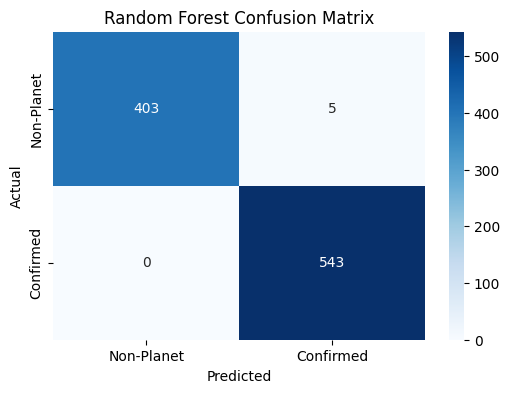

                                    Feature  Importance
2               Number of planets in system    0.491541
0                              default_flag    0.089622
36       System distance (- variation) (pc)    0.037648
15  Planet radius (- variation) (R_Jupiter)    0.034037
35       System distance (+ variation) (pc)    0.033780
19  Host star temperature (+ variation) (K)    0.028960
11    Planet radius (- variation) (R_Earth)    0.028550
20  Host star temperature (- variation) (K)    0.021434
14  Planet radius (+ variation) (R_Jupiter)    0.016317
10    Planet radius (+ variation) (R_Earth)    0.015878


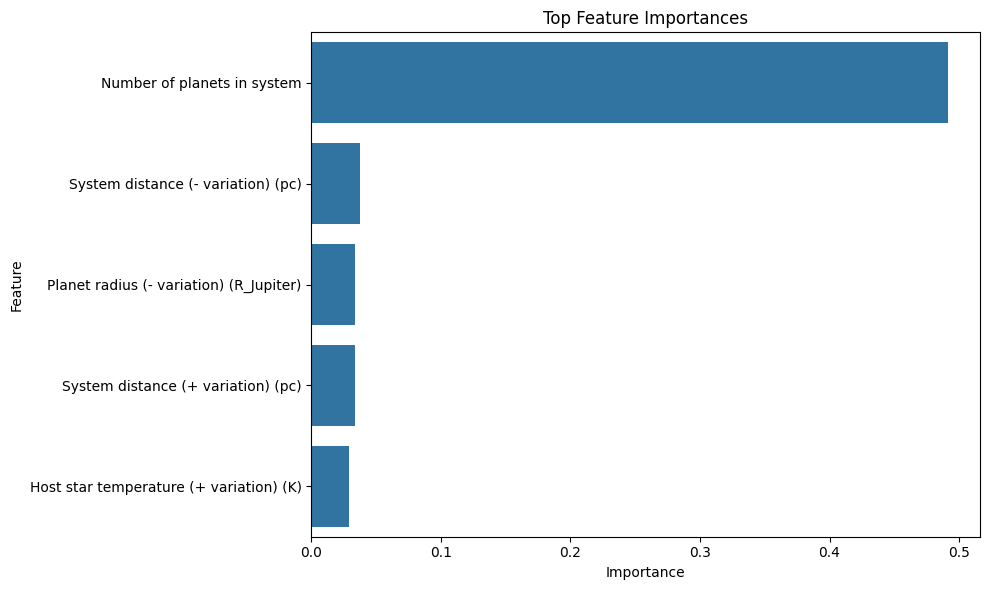

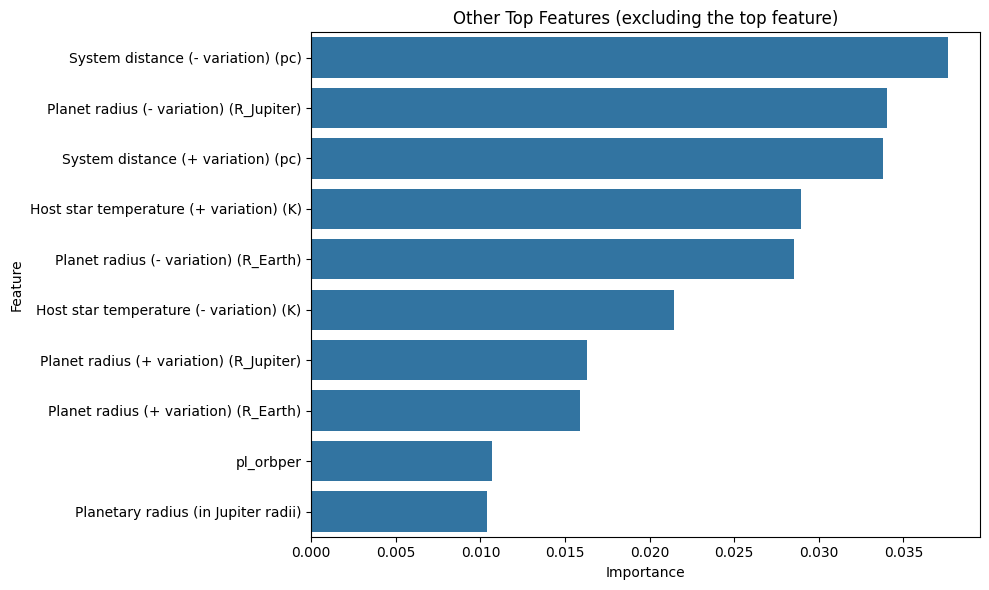

In [87]:
# Random Forest Classifier - Classical machine learning analysis

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


# Instantiate Random Forest with anti-overfitting tweaks
# Initially the model returned a suspicious 100% accuracy, so added more anti-overfitting parameters
rf = RandomForestClassifier(
    n_estimators=100,       # number of trees
    min_samples_split=10,   # minimum samples to split a node
    max_features='sqrt',    # only consider sqrt(total_features) per split
    random_state=42
)

# RUNNING THE MODEL
# Fit the model
rf.fit(X_train_normalized, y_train)

# Predict
y_pred = rf.predict(X_test_normalized)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


#VISUALISATION OF RESULTS -
# Visualise confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Planet','Confirmed'], yticklabels=['Non-Planet','Confirmed'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()


# A dictionary of human-readable names for important columns:
readable_names = {
    'sy_pnum': 'Number of planets in system',
    'st_masserr1': 'Host star mass (+ variation) (Solar masses)',
    'st_masserr2': 'Host star mass (- variation) (Solar masses)',
    'sy_disterr1': 'System distance (+ variation) (pc)',
    'sy_disterr2': 'System distance (- variation) (pc)',
    'pl_orbsmaxerr1': 'Semi-major axis (+ variation) (AU)',
    'pl_orbsmaxerr2': 'Semi-major axis (- variation) (AU)',
    'pl_radjerr2': 'Planet radius (- variation) (R_Jupiter)',
    'pl_radjerr1': 'Planet radius (+ variation) (R_Jupiter)',
    'pl_radeerr1': 'Planet radius (+ variation) (R_Earth)',
    'pl_radeerr2': 'Planet radius (- variation) (R_Earth)',
    'pl_rade': 'Planet radius (R_Earth)',
    'sy_dist': 'System distance (pc)',
    'st_tefferr2': 'Host star temperature (- variation) (K)',
    'st_tefferr1': 'Host star temperature (+ variation) (K)',
    'st_mass': 'Host star mass (Solar masses)',
    'pl_orbsmaxlim': 'Semi-major axis limit flag',
    'pl_radj' : 'Planetary radius (in Jupiter radii)',
    'sy_kmag' : 'Star brightness (infrared, K-band)'
}

# Get feature importances
importances = rf.feature_importances_
feature_names = X_train.columns


# Map to human-readable names if available
readable_feature_names = [readable_names.get(f, f) for f in feature_names]

# Take a look at most important features in the categorisation
feat_imp_df = pd.DataFrame({
    'Feature': readable_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print(feat_imp_df.head(10))

# Remove redundant features for categorisation
feat_imp_df = feat_imp_df[~feat_imp_df['Feature'].isin(['default_flag', 'disc_year'])]


# Separate the top feature with highest domainance
# (it overshadows the sensitivity of other features)
top_feature = 'Number of planets in system'
top_feat_df = feat_imp_df[feat_imp_df['Feature'] == top_feature]
other_feats_df = feat_imp_df[feat_imp_df['Feature'] != top_feature]


# Plot top 10 most important features,
# this is highlighting the importance of features highly correlated with the presence of confirmed exoplanets
feat_imp_df = feat_imp_df.head(5)



with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
plt.figure(figsize=(10,6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feat_imp_df,
   # palette='viridis',
    legend=False # <-- disables extra legend
)

plt.title('Top Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


# Bar chart for other key features
# Plot the remaining features (top 15)
plt.figure(figsize=(10,6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=other_feats_df.head(10),
     legend=False # <-- disables extra legend
)

plt.title('Other Top Features (excluding the top feature)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()





In [95]:
# PREPROCESSING DATA FOR NEURAL NETWORK MODEL
# Adding class weights to balance the minority class (confirmed exoplanets)
# Preferred this strategy than oversampling the exoplanets which would generate false data

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))
print("Class weights:", class_weights_dict)


# Soften extreme weights by applying an exponent < 1 - to prevent an over-confident model!
soft_class_weights_dict = {k: v**0.5 for k, v in class_weights_dict.items()}
print("Softened class weights:", soft_class_weights_dict)



Class weights: {np.int64(0): np.float64(1.1651676206050694), np.int64(1): np.float64(0.8758451137062078)}
Softened class weights: {np.int64(0): np.float64(1.079429303199181), np.int64(1): np.float64(0.9358659699477312)}


In [105]:
from tensorflow.keras.layers import Dense, Dropout, ReLU, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2

#Building Neural Network Model
model=Sequential()

# Add input layer

model.add(Dense(
    units=32,
    activation='relu',
    input_shape=(X_train_normalized.shape[1],),
    kernel_regularizer=l2(0.001)
))


# Add hidden layers
model.add(Dense(units=16,activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(8))
model.add(Dropout(0.6)) # High dropout as data sample is small
model.add(Dense(units=8,activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.6))


# Add the output layer
model.add(Dense(units=1,activation='sigmoid'))  # For binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
model.summary()



Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_97 (Dense)                │ (None, 32)             │         1,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,249 (8.79 KB)

 Trainable params: 2,249 (8.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5178 - loss: 0.8794 - val_accuracy: 0.6754 - val_loss: 0.7344
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5956 - loss: 0.7595 - val_accuracy: 0.8158 - val_loss: 0.6849
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6670 - loss: 0.7034 - val_accuracy: 0.8351 - val_loss: 0.6342
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7234 - loss: 0.6500 - val_accuracy: 0.8526 - val_loss: 0.5882
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7484 - loss: 0.6246 - val_accuracy: 0.8614 - val_loss: 0.5390
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7713 - loss: 0.6045 - val_accuracy: 0.8719 - val_loss: 0.4906
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8028 - loss: 0.5558 - val_accuracy: 0.8860 - val_loss: 0.4446
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8284 - loss: 0.5326 - val_accuracy: 0.9053 - val_loss

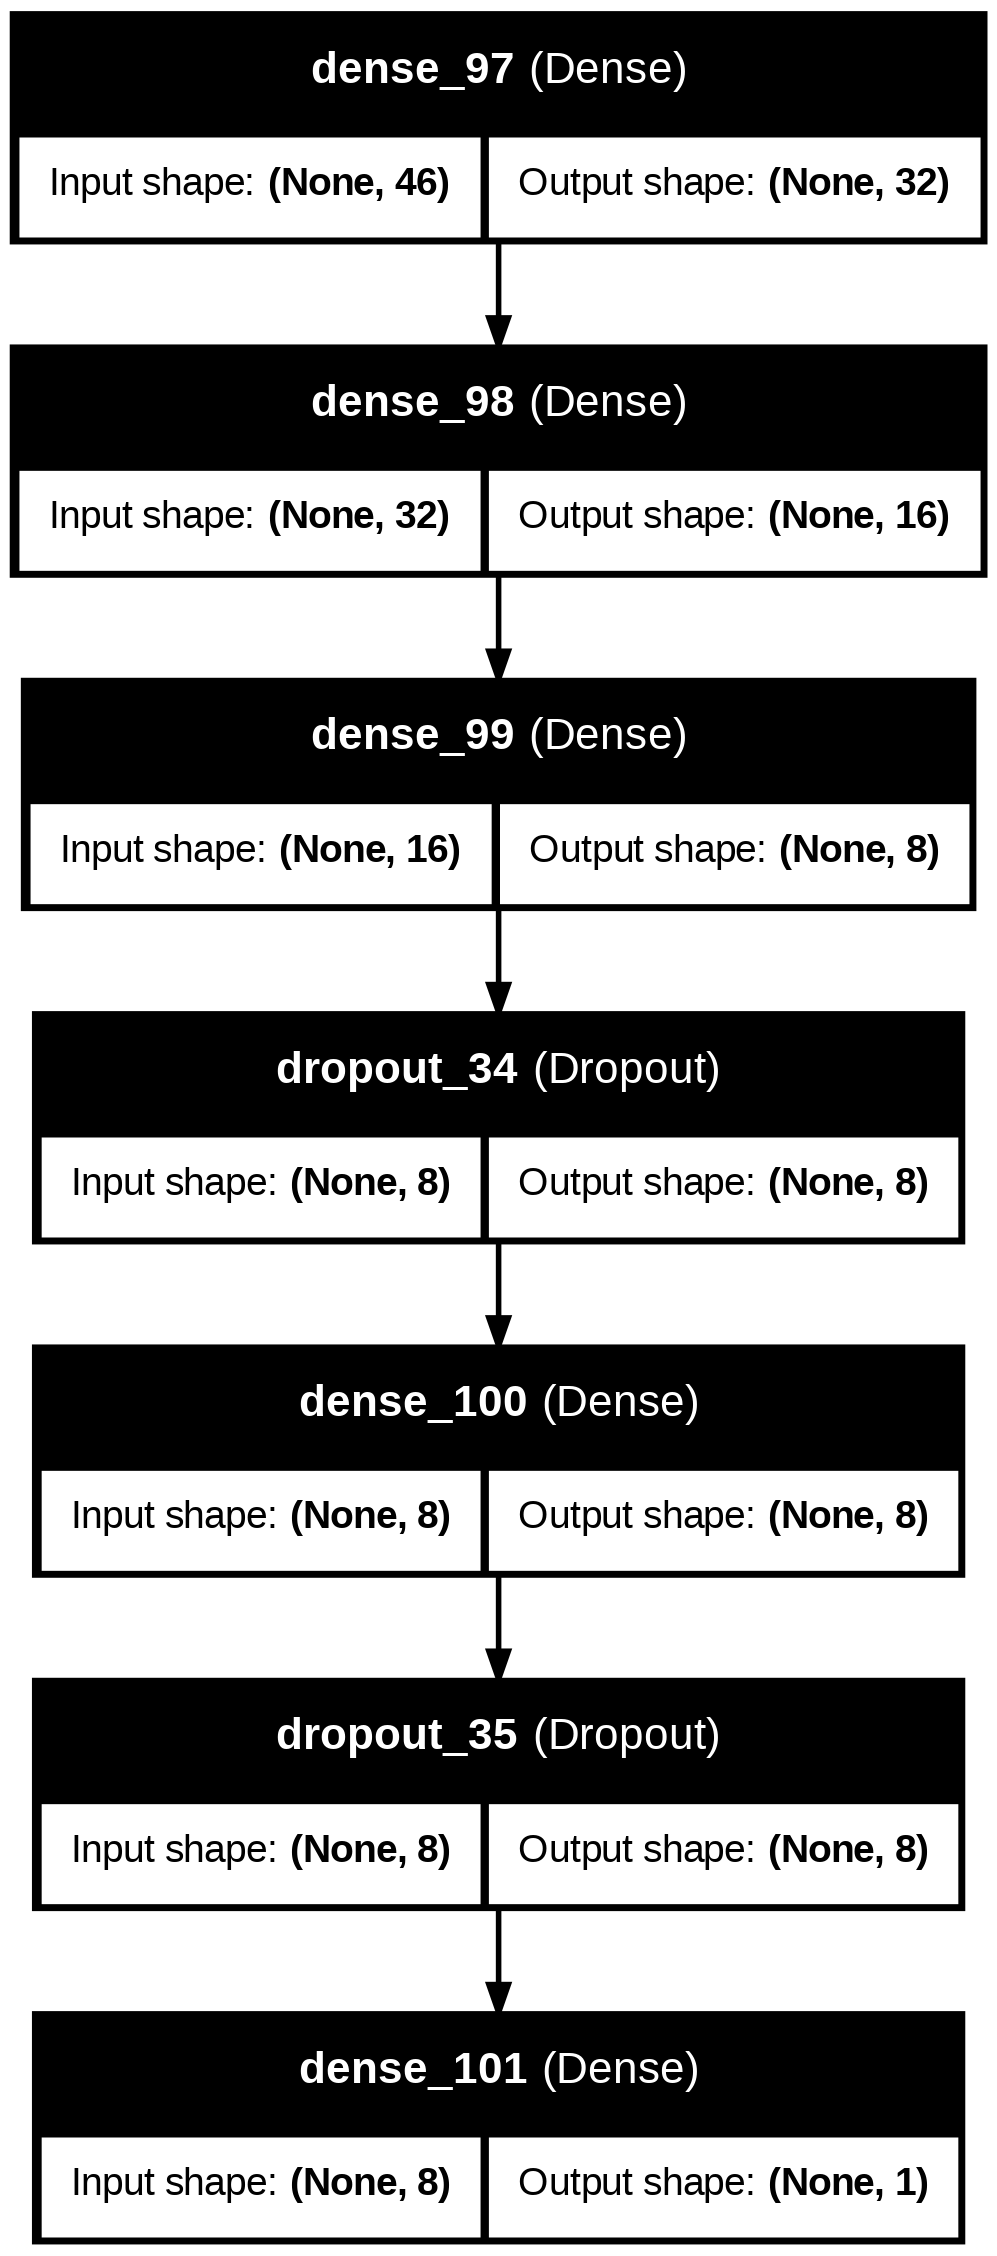

In [106]:

# Train the model

history = model.fit(X_train_normalized, y_train, epochs=50, batch_size=32, validation_split=0.2,  class_weight=soft_class_weights_dict)

# make predictions
y_pred_prob = model.predict(X_test_normalized)
y_pred = (y_pred_prob > 0.5).astype(int)


# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_normalized, y_test)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Plot the model architecture and display it
plot_file = 'model_plot.png'
plot_model(model, to_file=plot_file, show_shapes=True, show_layer_names=True)

# Display the plot inline
display(Image(filename=plot_file))


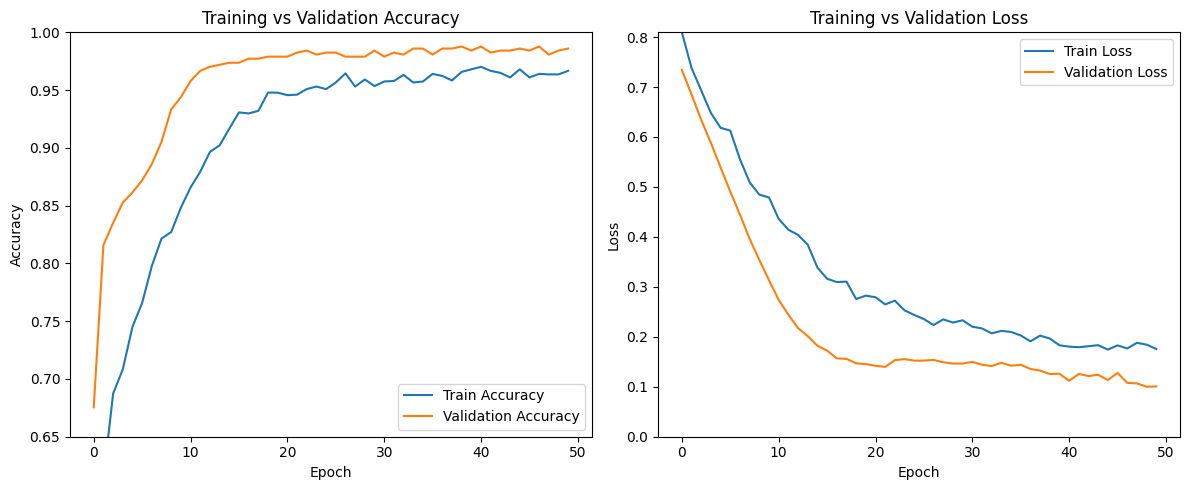

              precision    recall  f1-score   support

  Non-planet       0.98      0.99      0.98       408
   Confirmed       0.99      0.99      0.99       543

    accuracy                           0.99       951
   macro avg       0.98      0.99      0.98       951
weighted avg       0.99      0.99      0.99       951

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


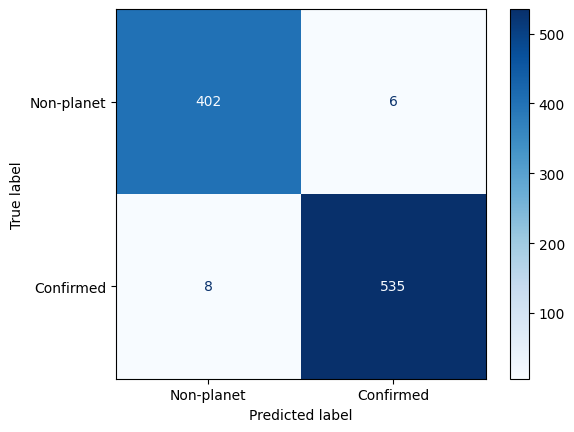

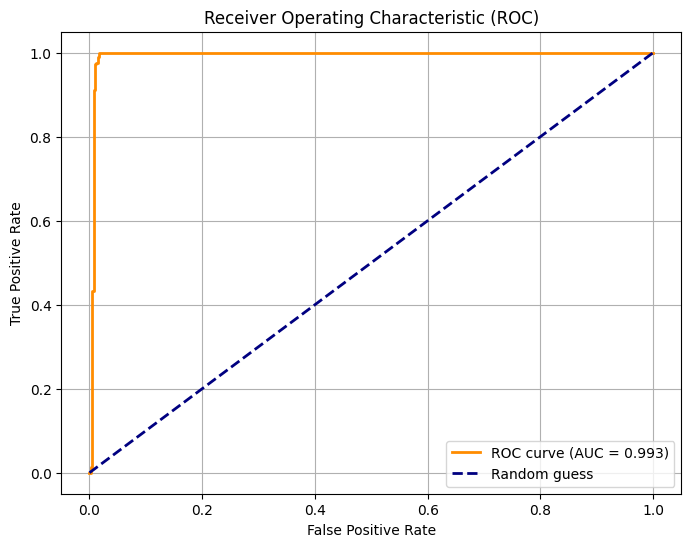

In [107]:
# VISUALISE THE RESULTS

# Plot accuracy and loss curves

plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.65, 1.0)  # zoom into the relevant range
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, max(history.history['loss'] + history.history['val_loss']))  # for loss
plt.legend()

plt.tight_layout()
plt.show()



# SHOW CONFUSION MATRIX
print(classification_report(y_test, y_pred, target_names=['Non-planet', 'Confirmed']))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-planet', 'Confirmed'])
disp.plot(cmap='Blues')


# ROC Curve
# Predict probabilities for the positive class
y_probs = model.predict(X_test_normalized).ravel()  # Flatten to 1D

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



In [ ]:
# @title
# #first we split then we normalize to prevent data leakage and increase accuracy
# l=['ExoplanetCandidate','ExoplanetConfirmed']
# X=df.drop(l,axis=1)  # Features (excluding the target column)
# y=df['ExoplanetCandidate']  # Target variable
# #Splitting
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=4000/7000, random_state=42,
#                                                     stratify=y # ensures class balance in train/test
# )

# Binary target: 1 = CONFIRMED (CONFIRMED exoplanets only), 0 = non-planets (CANDIDATE, FALSE POSITIVE, REFUTED, etc.)
df['ConfirmedExoplanet'] = df['disposition'].apply(lambda x: 1 if x == 'CONFIRMED' else 0)

# Select numeric columns as features
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in ['ConfirmedExoplanet']]
X = df[feature_cols]
y = df['ConfirmedExoplanet']


# #Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,
                                                    stratify=y # ensures class balance in train/test
 )

print("Training set distribution:\n", y_train.value_counts())
print("Testing set distribution:\n", y_test.value_counts())


#Normalizatiom
scaler=StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)


